# Vehicle Detection Project
#### Implementation of Vehicle Detection Project to images and video. It dependes of the parameters.p (It was generated by Vehicle-detection-training.ipynb)

In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import os
import fnmatch
from PIL import Image
from skimage.feature import hog
%matplotlib inline
from lesson_functions import *
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.model_selection import train_test_split
from scipy.ndimage.measurements import label
import pickle

In [2]:
def undistort_image(img,mtx, dist):
    return  cv2.undistort(img, mtx, dist, None, mtx)
           
def find_cars(img,x_start_stop,y_start_stop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    #draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    box_list = []
    ystart = y_start_stop[0]
    ystop = y_start_stop[1]
    
    xstart = x_start_stop[0]
    xstop = x_start_stop[1]
    
    img_tosearch = img[ystart:ystop,xstart:xstop,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    img_tosearch1 = np.copy(img_tosearch)
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell)-1
    nyblocks = (ch1.shape[0] // pix_per_cell)-1 
    nfeat_per_block = orient*cell_per_block**2
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell)-1 
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    #
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1,hog_feat2,hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)


            # Scale features and make a prediction
            B=np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1)
            #B=np.hstack((spatial_features, hog_features)).reshape(1, -1)
            test_features = X_scaler.transform(B)
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                # Assuming each "box" takes the form ((x1, y1), (x2, y2))
                box = [[xbox_left+xstart,ytop_draw+ystart],[xbox_left+win_draw+xstart,win_draw+ystart]]
                box_list.append (box)
                
                
    return  box_list

def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    if conv == 'RGB2HSV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    if conv == 'RGB2GRAY':
        return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    lbox = []
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        lbox.append(bbox)
        
    nlbox=[]
    box_merged = []
    for i in range(len(lbox)-1):
        ix1, iy1 = lbox[i][0][0], lbox[i][0][1]
        ix2, iy2 = lbox[i][1][0], lbox[i][1][1]
        iycenter = (iy2+iy1)/2
        for j in range(i+1,len(lbox)):   
            jx1, jy1 = lbox[j][0][0], lbox[j][0][1]
            jx2, jy2 = lbox[j][1][0], lbox[j][1][1]
            jycenter = (jy2+jy1)/2 #Eliminate boxes that are very close.
            if ((abs(jx1 - ix2)<16) or (abs(ix1 - jx2)<16)) and (((iy1<jycenter) and (iy2>jycenter)) or ((jy1<iycenter) and (jy2>iycenter))) :
                bbox = ((np.min([ix1,jx1]), np.min([iy1,jy1]) ),(np.max([ix2,jx2]), np.max([iy2,jy2] )))
                nlbox.append(bbox)
                box_merged.append(i)
                box_merged.append(j)
    
    for index in range(len(lbox)):
        if index not in box_merged:
            ix1, iy1 = lbox[index][0][0], lbox[index][0][1]
            ix2, iy2 = lbox[index][1][0], lbox[index][1][1]
            if (abs(ix1-ix2) >50) and (abs(iy1-iy2) >50):
                nlbox.append(lbox[index] )
    for bbox in nlbox:
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img, nlbox

In [3]:
def get_cars (image, split_result = False):
    global mtx 
    global dist 
    global svc
    global X_scaler
    global orient 
    global pix_per_cell
    global cell_per_block
    global spatial_size
    global hist_bins
    global area_of_interest
    global lbox 
    
    undis_image = undistort_image(image, mtx,dist)
    box_list = []
    for index in range(len(area_of_interest['x_start_stop'])):
        x_start_stop = area_of_interest['x_start_stop'][index]
        y_start_stop = area_of_interest['y_start_stop'][index]
        scale = area_of_interest['scale'][index]
        box_list.extend(find_cars(undis_image, x_start_stop,y_start_stop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins))
    heat = np.zeros_like(undis_image[:,:,0]).astype(np.float)
    heat = add_heat(heat,box_list)
    heat = add_heat(heat,lbox) #Use the data from the previous frame
    
    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,2)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)

    output_img,lbox = draw_labeled_bboxes(np.copy(undis_image), labels)
    
    draw_img=np.copy(undis_image)
    for box in box_list:
        cv2.rectangle(draw_img,(box[0][0], box[0][1]),(box[1][0], box[1][1]),(255,0,0),4) 

    ##show_information
    if split_result==False:
        g_scale = 0.25
        heatmap_img=cv2.cvtColor(heatmap.astype(np.uint8)*255, cv2.COLOR_GRAY2RGB)    
        heatmap_img = cv2.applyColorMap(heatmap_img, cv2.COLORMAP_HOT);
        image_overlay1 = cv2.resize(draw_img, (0,0), fx=g_scale, fy=g_scale) 
        image_overlay2 = cv2.resize(heatmap_img, (0,0), fx=g_scale, fy=g_scale) 
        Minimage_size = (image_overlay1.shape[0], image_overlay1.shape[1])
        output_img[0:Minimage_size[0], 0:Minimage_size[1]] = image_overlay1
        output_img[0:Minimage_size[0], Minimage_size[1]:2*Minimage_size[1]] = image_overlay2

        lindex = 0
        lbox.sort()
        for car_box in lbox:
            car = undis_image[car_box[0][1]:car_box[1][1],car_box[0][0]:car_box[1][0],:]
            car = cv2.resize(car, (128,96)) 
            output_img[25 + ((lindex//3)*121):((lindex//3)*121)+121,  680 + ((lindex % 3)*168):808 + ((lindex%3)*168)] = car
            lindex = lindex+1
    else:
        return output_img, draw_img, heatmap, labels 
    
    return output_img 
            

In [4]:
##Read the parameters for undistort the image
dist_pickle = pickle.load( open( "wide_dist_pickle.p", "rb" ) )
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]

##Read the parameters for feature extraction and trained classifier
dist_pickle = pickle.load( open("parameters.p", "rb" ) )
svc = dist_pickle["svc"]
X_scaler = dist_pickle["X_scaler"]
orient = dist_pickle["orient"]
pix_per_cell = dist_pickle["pix_per_cell"]
cell_per_block = dist_pickle["cell_per_block"]
spatial_size = dist_pickle["spatial_size"]
hist_bins = dist_pickle["hist_bins"]

##Get Area of interest:
area_of_interest= {}
area_of_interest['x_start_stop'] = [[660,1280] ,[590,1280],[448,1280],[320,1280]]
area_of_interest['y_start_stop'] = [[400,520],[410,580]  ,[420,660] ,[450,720]]
area_of_interest['scale']  =         [1.25,1.5,2,3]

### Example of images processed:

In [5]:
input_dir="test_images/"
output_dir="output_images/"
dirs = os.listdir(input_dir)
loutput_img = []
ldraw_img=[]
lheatmap =[]
llabels=[]
images =[]
filenames = []


for file in dirs:
    if (file.find("test")==0):
        image =  mpimg.imread(input_dir+file)
        image = undistort_image(image, mtx,dist)
        lbox =[] #list of cars found in the last frame, in this case there isn't previous frame
        output_img, draw_img, heatmap, labels  = get_cars(image,split_result = True)
        loutput_img.append(output_img)
        ldraw_img.append(draw_img)
        lheatmap.append(heatmap)
        llabels.append(labels[0])
        cv2.imwrite(output_dir+file, cv2.cvtColor(output_img, cv2.COLOR_RGB2BGR))  
        filenames.append(file)
        

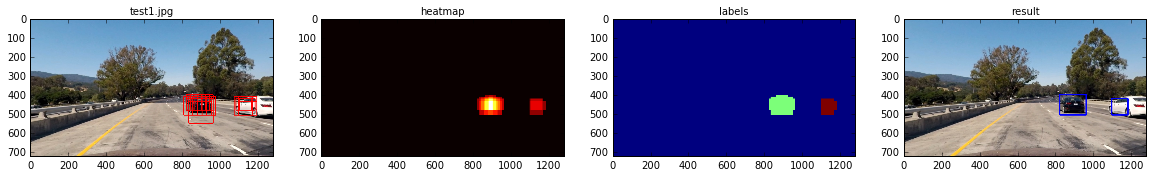

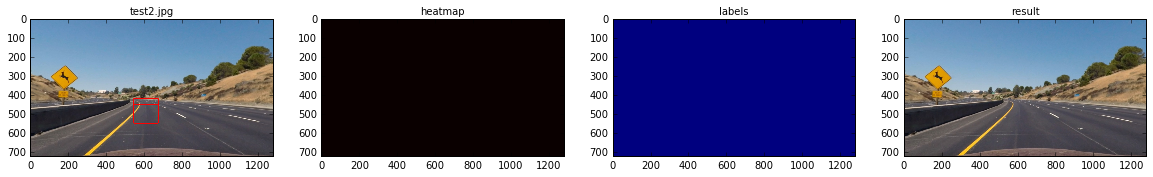

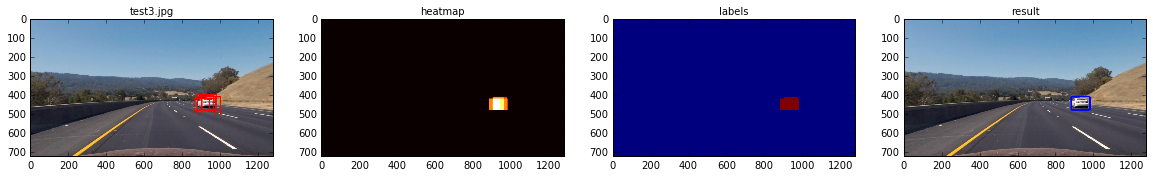

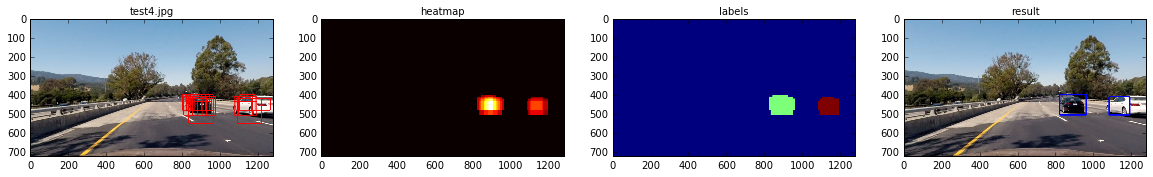

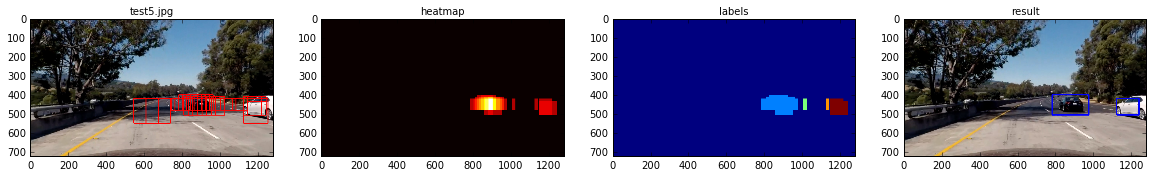

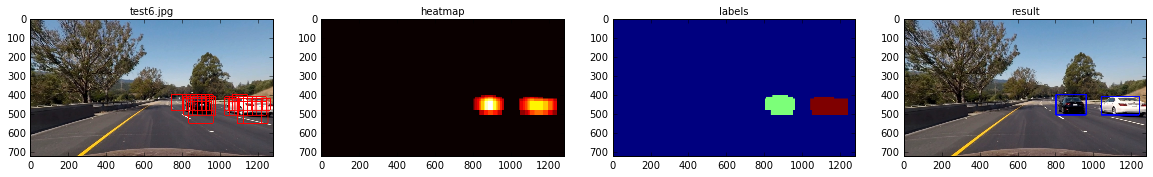

In [6]:
for index in range(len(loutput_img)):
    f, (ax1, ax2,ax3,ax4) = plt.subplots(1, 4, figsize=(20,10))
    ax1.imshow(ldraw_img[index])
    ax1.set_title(filenames[index], fontsize=10)
    ax2.imshow(lheatmap[index], cmap='hot')
    ax2.set_title('heatmap', fontsize=10)
    ax3.imshow(llabels[index])
    ax3.set_title('labels', fontsize=10)
    ax4.imshow(loutput_img[index])
    ax4.set_title('result', fontsize=10)

In [7]:
lbox =[]
from moviepy.editor import VideoFileClip
from IPython.display import HTML
challenge_output = 'test_video_output.mp4'
clip2 = VideoFileClip('test_video.mp4')
challenge_clip = clip2.fl_image(get_cars)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video test_video_output.mp4
[MoviePy] Writing video test_video_output.mp4


 97%|███████████████████████████████████████████████████████████████████████████████▉  | 38/39 [00:41<00:01,  1.10s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_output.mp4 

Wall time: 45.7 s


In [8]:
lbox =[]
from moviepy.editor import VideoFileClip
from IPython.display import HTML
challenge_output = 'project_video_output.mp4'
clip2 = VideoFileClip('project_video.mp4')
challenge_clip = clip2.fl_image(get_cars)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [26:45<00:01,  1.16s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

Wall time: 26min 48s
